# Shape detection

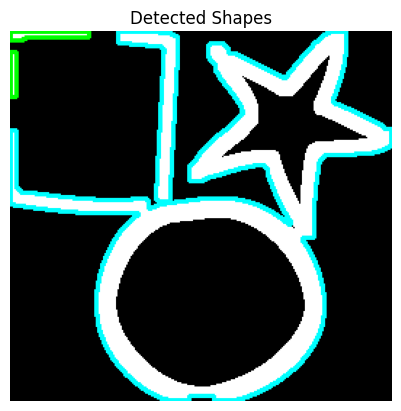

Detected shape: circle
Detected shape: star
Detected shape: rounded rectangle


In [6]:
import cairosvg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Convert SVG to PNG with transparency support
svg_file = 'C:/Users/arush/OneDrive/Documents/problems/isolated.svg'
png_file = 'temp_image.png'
cairosvg.svg2png(url=svg_file, write_to=png_file, background_color=None)

# Open the image with PIL
image_pil = Image.open(png_file)

# Convert RGBA to RGB, replacing transparency with white
if image_pil.mode == 'RGBA':
    image_rgb = Image.new('RGB', image_pil.size, (255, 255, 255))
    image_rgb.paste(image_pil, (0, 0), image_pil)
else:
    image_rgb = image_pil.convert('RGB')

# Save the RGB image as PNG
image_rgb.save('temp_image_rgb.png')

# Read the converted PNG image using OpenCV
image = cv2.imread('temp_image_rgb.png', cv2.IMREAD_GRAYSCALE)

# Apply Gaussian blur with adjusted parameters
blurred_image = cv2.GaussianBlur(image, (7, 7), 2)

# Apply adaptive thresholding with adjusted parameters
binary_image = cv2.adaptiveThreshold(blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 21, 15)

# Apply morphological operations to clean up the image
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
morph_open = cv2.morphologyEx(binary_image, cv2.MORPH_OPEN, kernel)
morph_close = cv2.morphologyEx(morph_open, cv2.MORPH_CLOSE, kernel)

# Apply Canny edge detection with adjusted thresholds
edges = cv2.Canny(morph_close, 50, 150)

# Apply dilation with more iterations to connect contours
dilated_edges = cv2.dilate(edges, None, iterations=3)

# Find contours
contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Initialize a set to store unique shape labels
shape_labels = set()

# Function to check if a shape is star-like
def is_star(contour):
    approx = cv2.approxPolyDP(contour, 0.03 * cv2.arcLength(contour, True), True)
    
    # Check the number of vertices; stars generally have between 10-12
    if len(approx) < 10 or len(approx) > 12:
        return False
    
    # Calculate the convex hull and check if the shape is concave
    hull = cv2.convexHull(contour, returnPoints=False)
    if len(hull) == len(approx):
        return False
    
    # Check for alternating long and short distances between points
    distances = []
    for i in range(len(approx)):
        pt1 = approx[i][0]
        pt2 = approx[(i + 2) % len(approx)][0]  # Skip one vertex to measure distance between alternating points
        dist = np.linalg.norm(pt1 - pt2)
        distances.append(dist)
    
    # Check for high variance in distances
    if np.std(distances) > 15:  # Adjust threshold as needed
        return True
    
    return False

# Function to classify shape based on contour
def classify_shape(contour):
    shape = "unknown"
    peri = cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, 0.03 * peri, True)
    num_vertices = len(approx)
    
    # Using bounding rectangle to differentiate shapes
    (x, y, w, h) = cv2.boundingRect(approx)
    
    if num_vertices == 2:
        shape = "line"
    elif num_vertices == 3:
        shape = "triangle"
    elif num_vertices == 4:
        aspect_ratio = w / float(h)
        if 0.9 <= aspect_ratio <= 1.1:
            shape = "square"
        else:
            shape = "rectangle"
        # Check for rounded rectangle
        if abs(cv2.arcLength(contour, True) - (2 * (w + h))) < 30:
            shape = "rounded rectangle"
    elif num_vertices == 5:
        shape = "pentagon"
    elif num_vertices == 6:
        shape = "hexagon"
    elif num_vertices > 6:
        (x, y), (MA, ma), angle = cv2.fitEllipse(contour)
        aspect_ratio = MA / ma
        if 0.8 <= aspect_ratio <= 1.2:
            shape = "circle"
        else:
            shape = "ellipse"
        # Check for star-like shapes
        if is_star(contour):
            shape = "star"
    
    return shape

# Read the original image for Hough Circle detection
image_color = cv2.imread('temp_image_rgb.png', cv2.IMREAD_COLOR)
gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

# Detect circles
circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, 20, param1=50, param2=30, minRadius=10, maxRadius=100)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(image_color, (x, y), r, (0, 255, 0), 2)
        shape_labels.add("circle")

# Draw contours and classify shapes
contour_image = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2BGR)
for contour in contours:
    if cv2.contourArea(contour) > 100:  # Filter out small contours
        shape = classify_shape(contour)
        shape_labels.add(shape)  # Use add() to avoid duplicates
        color = (0, 255, 0)  # Green for contours
        if shape == "line":
            color = (255, 0, 0)  # Red for lines
        elif shape == "circle":
            color = (0, 0, 255)  # Blue for circles
        elif shape == "star":
            color = (255, 255, 0)  # Yellow for stars
        cv2.drawContours(contour_image, [contour], -1, color, 2)

# Display the processed image with contours and shapes
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title('Detected Shapes')
plt.axis('off')
plt.show()

# Print unique shape classifications
for label in shape_labels:
    print(f"Detected shape: {label}")


# Symmetry Hunt

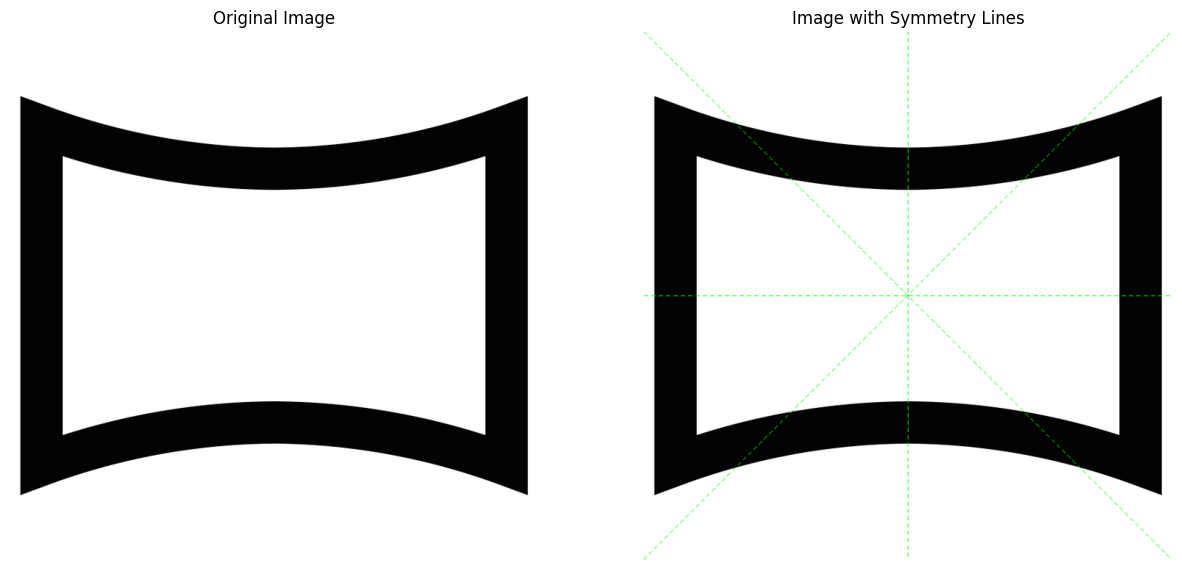

Contour at (359, 360): vertical, horizontal, diagonal1, diagonal2


In [7]:
import cairosvg
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim

# Convert SVG to PNG with transparency support
svg_file = r"C:\Users\arush\Downloads\shape-svgrepo-com.svg"   #Taking any random image for testing
png_file = 'temp_image.png'
cairosvg.svg2png(url=svg_file, write_to=png_file, background_color=None)

# Open the image with PIL and resize
image_pil = Image.open(png_file)
resize_scale = 0.9  # Reduce the size to half
new_size = (int(image_pil.width * resize_scale), int(image_pil.height * resize_scale))
image_pil = image_pil.resize(new_size, Image.LANCZOS)

# Convert RGBA to RGB and save
if image_pil.mode == 'RGBA':
    image_rgb = Image.new('RGB', image_pil.size, (255, 255, 255))
    image_rgb.paste(image_pil, (0, 0), image_pil)
else:
    image_rgb = image_pil.convert('RGB')
png_rgb_file = 'temp_image_rgb.png'
image_rgb.save(png_rgb_file)

# Load the resized image with OpenCV
image_cv = cv2.imread(png_rgb_file)
gray_image = cv2.cvtColor(image_cv, cv2.COLOR_BGR2GRAY)

# Adaptive thresholding to handle variations in hand-drawn shapes
binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 21,15)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def draw_dotted_line(image, start_point, end_point, color, thickness, gap=10):
    """Draws a dotted line on the image."""
    dist = np.linalg.norm(np.array(end_point) - np.array(start_point))
    num_segments = int(dist // gap)
    for i in range(num_segments + 1):
        start = tuple(np.add(start_point, np.multiply(np.divide(np.subtract(end_point, start_point), num_segments), i)).astype(int))
        end = tuple(np.add(start_point, np.multiply(np.divide(np.subtract(end_point, start_point), num_segments), i + 0.5)).astype(int))
        cv2.line(image, start, end, color, thickness)

def draw_symmetry_line(image, line_type, center):
    """Draws symmetry lines on the image that intersect at the center."""
    height, width = image.shape[:2]
    color = (0, 255, 0)  # Green for symmetry lines
    thickness = 1

    if line_type == 'vertical':
        draw_dotted_line(image, (center[0], 0), (center[0], height), color, thickness)
    elif line_type == 'horizontal':
        draw_dotted_line(image, (0, center[1]), (width, center[1]), color, thickness)
    elif line_type == 'diagonal1':  # Diagonal from top-left to bottom-right
        top_left = (center[0] - min(center[0], center[1]), center[1] - min(center[0], center[1]))
        bottom_right = (center[0] + min(width - center[0], height - center[1]), 
                        center[1] + min(width - center[0], height - center[1]))
        draw_dotted_line(image, top_left, bottom_right, color, thickness)
    elif line_type == 'diagonal2':  # Diagonal from bottom-left to top-right
        bottom_left = (center[0] - min(center[0], height - center[1]), center[1] + min(center[0], height - center[1]))
        top_right = (center[0] + min(width - center[0], center[1]), center[1] - min(width - center[0], center[1]))
        draw_dotted_line(image, bottom_left, top_right, color, thickness)


def check_symmetry_line(contour, line_type, tolerance=0.05):
    """Checks if a symmetry line is present."""
    mask = np.zeros(binary_image.shape, dtype=np.uint8)
    cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)

    if line_type == 'vertical':
        M = np.float32([[1, 0, 0], [0, -1, mask.shape[0]]])
    elif line_type == 'horizontal':
        M = np.float32([[-1, 0, mask.shape[1]], [0, 1, 0]])
    elif line_type == 'diagonal1':
        M = cv2.getRotationMatrix2D((mask.shape[1]//2, mask.shape[0]//2), 45, 1.0)
    elif line_type == 'diagonal2':
        M = cv2.getRotationMatrix2D((mask.shape[1]//2, mask.shape[0]//2), -45, 1.0)
    else:
        return False

    reflected = cv2.warpAffine(mask, M, (mask.shape[1], mask.shape[0]))
    similarity = ssim(mask, reflected)

    return similarity >= (1 - tolerance)

def find_lines_of_symmetry(contours, tolerance=0.8):
    """Finds and draws lines of symmetry for all detected contours."""
    symmetry_types = ['vertical', 'horizontal', 'diagonal1', 'diagonal2']
    detected_symmetries = []

    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        center = (x + w // 2, y + h // 2)
        detected_for_this_contour = []

        for line_type in symmetry_types:
            if check_symmetry_line(contour, line_type, tolerance):
                detected_for_this_contour.append(line_type)
                draw_symmetry_line(image_cv, line_type, center)

        if detected_for_this_contour:
            detected_symmetries.append(f"Contour at {center}: {', '.join(detected_for_this_contour)}")
    
    # Save the image with drawn symmetry lines and labels
    annotated_image_path = 'annotated_image.png'
    cv2.imwrite(annotated_image_path, image_cv)

    # Display the original and annotated images side by side
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    
    # Original Image
    axs[0].imshow(cv2.cvtColor(cv2.imread(png_rgb_file), cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    # Annotated Image with Symmetry Lines
    axs[1].imshow(cv2.cvtColor(image_cv, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Image with Symmetry Lines')
    axs[1].axis('off')

    plt.show()

    # Print detected symmetries below the images
    for symmetry in detected_symmetries:
        print(symmetry)

# Apply the symmetry check to all contours and draw lines of symmetry
find_lines_of_symmetry(contours)


# Curve Completion

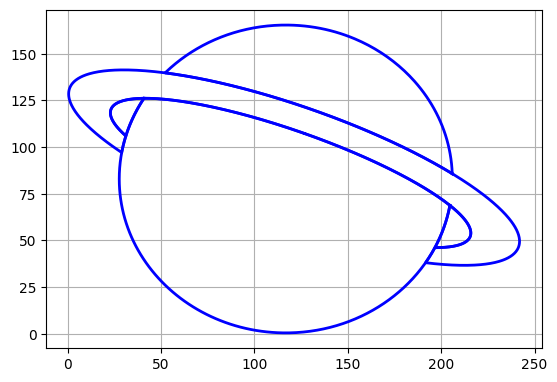

In [8]:
import svgpathtools
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import svgwrite

def load_svg(file_path):
    """Load SVG file and extract paths."""
    paths, _ = svgpathtools.svg2paths(file_path)
    return paths

def extract_coordinates(path):
    """Extract coordinates from SVG path segments."""
    coords = []
    for segment in path:
        if isinstance(segment, svgpathtools.Line):
            coords.append((segment.start.real, segment.start.imag))
            coords.append((segment.end.real, segment.end.imag))
        elif isinstance(segment, (svgpathtools.CubicBezier, svgpathtools.QuadraticBezier)):
            for t in np.linspace(0, 1, num=100):
                point = segment.point(t)
                coords.append((point.real, point.imag))
    coords = list(dict.fromkeys(coords))  # Remove duplicate points
    return coords

def identify_gaps(curve, threshold=10):
    """Identify gaps in a curve based on a distance threshold."""
    gaps = []
    for i in range(len(curve) - 1):
        dist = np.linalg.norm(np.array(curve[i]) - np.array(curve[i + 1]))
        if dist > threshold:
            gaps.append((curve[i], curve[i + 1]))
    return gaps

def complete_curve_linear(gaps):
    """Complete the curve by linearly interpolating the gaps."""
    completed_curve = []
    for start, end in gaps:
        line = np.linspace(start, end, num=100)
        completed_curve.extend(line)
    return completed_curve

def plot_curves(original_curves, completed_curves):
    """Plot the original and completed curves."""
    fig, ax = plt.subplots()
    for curve in original_curves:
        coords = np.array(curve)
        ax.plot(coords[:, 0], coords[:, 1], 'b-', lw=2)

    for curve in completed_curves:
        coords = np.array(curve)
        ax.plot(coords[:, 0], coords[:, 1], 'r--', lw=2)
    
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()

def save_svg(completed_curves, output_svg):
    """Save the completed curves to a new SVG file."""
    dwg = svgwrite.Drawing(output_svg, profile='tiny')
    for curve in completed_curves:
        coords = np.array(curve)
        path_data = "M " + " L ".join(f"{x},{y}" for x, y in coords)
        dwg.add(dwg.path(d=path_data, stroke=svgwrite.rgb(10, 10, 16, '%'), fill="none"))
    dwg.save()

def main(input_svg, output_svg):
    # Step 1: Load the SVG
    paths = load_svg(input_svg)
    
    # Step 2: Extract original curves
    original_curves = [extract_coordinates(path) for path in paths]
    
    # Step 3: Identify and complete curves
    completed_curves = []
    for curve in original_curves:
        gaps = identify_gaps(curve)
        if gaps:
            completed_curve = complete_curve_linear(gaps)
            completed_curves.append(completed_curve)
    
    # Step 4: Plot the results
    plot_curves(original_curves, completed_curves)
    
    # Step 5: Save the completed curves to a new SVG file
    save_svg(completed_curves, output_svg)

if __name__ == "__main__":
    input_svg = r"C:\Users\arush\Downloads\occlusion2.svg"
    output_svg = r"C:\Users\arush\Downloads\occlusion2_completed.svg"
    main(input_svg, output_svg)


# Curve Completion via splines Fitting and Interpolation

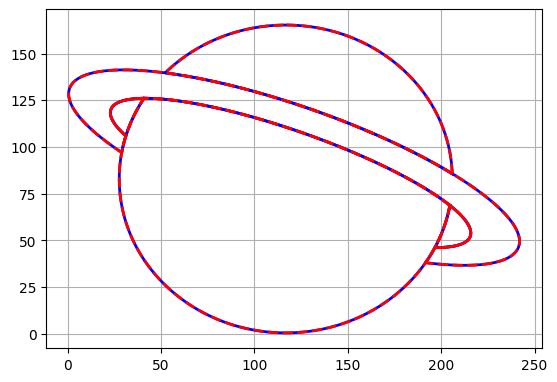

In [1]:
import svgpathtools
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev

def load_svg(file_path):
    paths, _ = svgpathtools.svg2paths(file_path)
    return paths

def extract_coordinates(path):
    coords = []
    for segment in path:
        if isinstance(segment, svgpathtools.Line):
            coords.append((segment.start.real, segment.start.imag))
            coords.append((segment.end.real, segment.end.imag))
        elif isinstance(segment, (svgpathtools.CubicBezier, svgpathtools.QuadraticBezier)):
            for t in np.linspace(0, 1, num=100):
                point = segment.point(t)
                coords.append((point.real, point.imag))
    # Remove duplicate points to avoid issues with spline fitting
    coords = list(dict.fromkeys(coords))
    return coords

def identify_gaps(curve):
    coords = np.array(curve)
    if len(coords) < 2:
        return None
    return coords[0], coords[-1]

def complete_curve_spline(endpoints, curve):
    x, y = zip(*curve)
    
    # Check if there are enough unique points for spline fitting
    if len(set(x)) < 2 or len(set(y)) < 2:
        raise ValueError("Not enough unique points for spline fitting.")
    
    try:
        tck, u = splprep([x, y], s=0, per=True)
    except Exception as e:
        print("Error during spline fitting:", e)
        return curve
    
    u_new = np.linspace(u.min(), u.max(), 1000)
    x_new, y_new = splev(u_new, tck, der=0)
    completed_curve = np.vstack((x_new, y_new)).T
    return completed_curve

def draw_curves(original_curves, completed_curves):
    fig, ax = plt.subplots()
    for curve in original_curves:
        ax.plot(curve[:, 0], curve[:, 1], 'b-', lw=2)  # Original curves in blue
    
    for curve in completed_curves:
        ax.plot(curve[:, 0], curve[:, 1], 'r--', lw=2)  # Completed curves in red
    
    ax.set_aspect('equal')
    plt.grid(True)
    plt.show()

def main(input_svg, output_image):
    paths = load_svg(input_svg)
    original_curves = []
    completed_curves = []
    
    for path in paths:
        coords = extract_coordinates(path)
        if len(coords) > 1:
            curve = np.array(coords)
            original_curves.append(curve)
            endpoints = identify_gaps(curve)
            if endpoints:
                completed_curve = complete_curve_spline(endpoints, curve)
                completed_curves.append(completed_curve)
    
    draw_curves(original_curves, completed_curves)

if __name__ == "__main__":
    input_svg = r"C:\Users\arush\Downloads\occlusion2.svg"
    output_image = 'completed_curves.png'
    main(input_svg, output_image)
